# Ecological Index - KGP validation plots
- Plot CESM data vs. observations
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- July 2025

In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
#import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import utils
import pandas as pd
import geopandas as gpd
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Load KGP data from OBS

In [6]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/validation_data/'

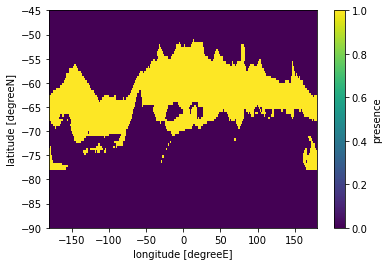

In [7]:
ds_aquamaps_krill_80 = xr.open_dataset(path_in+'Reviewed_Euphausia_superba_modelgrid_80pct.nc')
ds_aquamaps_krill_80.presence.plot()


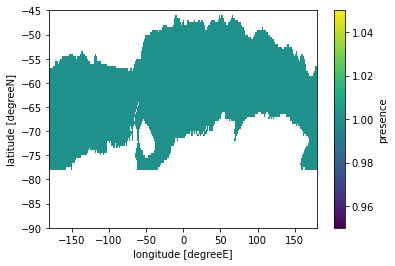

In [8]:
ds_aquamaps_krill_0 = xr.open_dataset(path_in+'Reviewed_Euphausia_superba_modelgrid_0pct.nc')
ds_aquamaps_krill_0.presence.plot()

## Load KGP data from CESM

In [9]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [10]:
# load hindcast data
file_in = 'CESM2-JRA55-hindcast-seasonal-integrals-KGP.nc'
ds_in = xr.open_dataset(path_in+file_in, decode_times=True)

# keep just the full growth season data
kgp_hindcast = ds_in.KGP_ONDJFM

In [11]:
# load cesm2-le data
file_in = 'CESM2-LE-seasonal-integrals-KGP.nc'
ds_in = xr.open_dataset(path_in+file_in, decode_times=True)

# keep just the full growth season data
kgp_cesm2le = ds_in.KGP_ONDJFM

In [12]:
# trim both datasets to 2003-2020
kgp_hindcast = kgp_hindcast.isel(time=slice(42,63))
kgp_cesm2le  = kgp_cesm2le.isel(time=slice(50,71))

In [13]:
# take averages over all years and all ensemble members (for cesm2-le)
kgp_hindcast_mean = kgp_hindcast.mean(dim=('time'))
kgp_cesm2le_mean = kgp_cesm2le.mean(dim=('time','member_id'))

## Plot figure

In [14]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [15]:
# get colony distance info for plotting
lons = ds_grid.TLONG
lats = ds_grid.TLAT

In [16]:
# mask to omit land points
kgp_hindcast_mean = kgp_hindcast_mean.where(ds_grid.REGION_MASK == 1)
kgp_cesm2le_mean = kgp_cesm2le_mean.where(ds_grid.REGION_MASK == 1)

### Set plotting ranges, etc.

In [17]:
# set some plotting info
cmap_in = cmocean.cm.amp
vmin_in = 0
vmax_in = 30.0
units = ds_in.KGP_ONDJFM.units

### Get shapefile with geography

In [18]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [19]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

### Create a custom colormap for the Aquamap

In [20]:
from matplotlib import colors as c
cMap_0 = c.ListedColormap(['darksalmon'])
cMap_80 = c.ListedColormap(['firebrick'])

# look at colormap
#data = np.random.rand(10, 10) # A 10x10 array of random values
#plt.imshow(data, cmap=cMap_80)

### Save plot

In [21]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_6/'
fout = 'SFigure_KGP_validation'

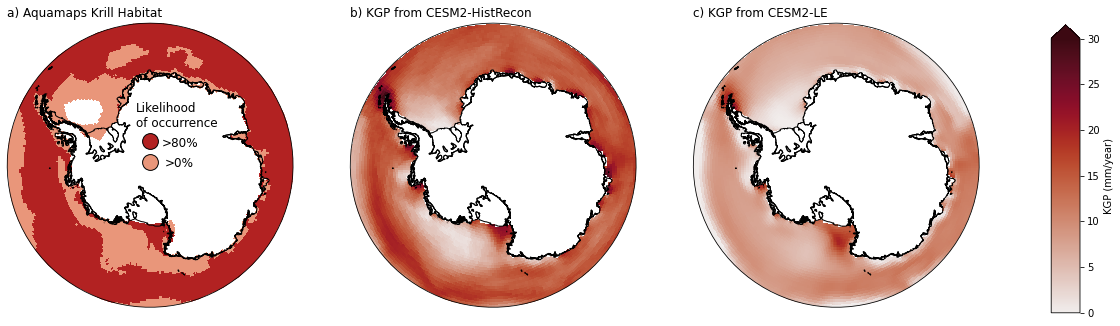

In [22]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))

# plot the region as subplots - note it's nrow x ncol x index (starting upper left)

### Plot Obs ###
ax = fig.add_subplot(1,3,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('a) Aquamaps Krill Habitat', loc='left')
# 0% occurrance
this=ax.pcolormesh(ds_aquamaps_krill_0.lon,ds_aquamaps_krill_0.lat,
                     ds_aquamaps_krill_0.presence.where(ds_aquamaps_krill_0.presence==1),
                     cmap=cMap_0,                      
                     transform=ccrs.PlateCarree())
# 80% occurrance
this=ax.pcolormesh(ds_aquamaps_krill_80.lon,ds_aquamaps_krill_80.lat,
                     ds_aquamaps_krill_80.presence.where(ds_aquamaps_krill_80.presence==1),
                     cmap=cMap_80,                      
                     transform=ccrs.PlateCarree())

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
# Add legend
this = ax.text(340.0,-81.0,'Likelihood\nof occurrence',color='black', fontsize='large',transform=ccrs.PlateCarree())
this = ax.scatter(0.0,-84.5, color='firebrick', edgecolor='black',s=250,transform=ccrs.PlateCarree())
this = ax.text(30.0,-85.0,'>80%',color='black', fontsize='large',transform=ccrs.PlateCarree())
this = ax.scatter(0.0,-89.0, color='darksalmon', edgecolor='black',s=250,transform=ccrs.PlateCarree())
this = ax.text(90.0,-87,'>0%',color='black', fontsize='large',transform=ccrs.PlateCarree())

### Plot CESM2 hindcast ###
ax = fig.add_subplot(1,3,2, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('b) KGP from CESM2-HistRecon', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,kgp_hindcast_mean)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot CESM2-LE ###
ax = fig.add_subplot(1,3,3, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('c) KGP from CESM2-LE', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,kgp_cesm2le_mean)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Add a common colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.2])
cbar1 = fig.colorbar(this, cax=cbar_ax,extend='max',label='KGP ('+units+')')

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)